In [1]:
import numpy as np
from scipy.optimize import fsolve
import scipy.integrate as integrate 
import matplotlib.pyplot as plt

In [5]:
dpgs_charge = -24
ca_charge   =   2
na_charge   =   1
cl_charge   =  -1
rd = 1.3778963802321125
vd = 4*np.pi/3*rd**3 #6.24

sigma_ca = 0.263 # 0.253760 ca
sigma_na = 0.258
sigma_cl = 0.440104

vol_ca = np.pi/6*sigma_ca**3
vol_na = np.pi/6*sigma_na**3
vol_cl = np.pi/6*sigma_cl**3

systems = {}
systems["nacl-100mM"] = [0.0000000, 0.0595398, 0.0537438, 1.78]
systems["nacl-150mM"] = [0.0000000, 0.0794375, 0.0745260, 1.78]
systems["netz-07mM"]  = [0.0042627, 0.0848139, 0.0923875, 1.93] 
#[0.0047453, 0.0904122, 0.0965279] 
systems["netz-20mM"]  = [0.0119045, 0.0853042, 0.1084460, 1.93] 
#[0.0125307, 0.0843833, 0.108683]# 
systems["netz-33mM"]  = [0.0208943, 0.0888704, 0.1300010, 1.95]
#systems["netz-17mM"]  = [0.0104131, 0.0746450, 0.0943733]
#systems["netz-18mM"]  = [0.0108298, 0.0869196, 0.106701]


#free bulk conc #ca_conc, na_conc, cl_conc, reff
M = [(0.0000000, 0.0595398, 0.0537438, 1.78),\
     (0.0000000, 0.0794375, 0.0745260, 1.78),\
     (0.0042627, 0.0848139, 0.0923875, 1.93),\
     (0.0119045, 0.0853042, 0.1084460, 1.93),\
     (0.0208943, 0.0888704, 0.1300010, 1.95)]
'''
# total conc #ca_conc, na_conc, cl_conc, reff
M = [[0.0000000, 0.09504246, 0.07051537, 1.78],\
     [0.0081797918, 0.09509007995, 0.08691028813, 1.93],\
     [0.016392099, 0.09527907548, 0.103475124989, 1.93],\
     [0.0276378823240, 0.09519715022, 0.12590590836, 1.95]]
'''

'\n# total conc #ca_conc, na_conc, cl_conc, reff\nM = [[0.0000000, 0.09504246, 0.07051537, 1.78],     [0.0081797918, 0.09509007995, 0.08691028813, 1.93],     [0.016392099, 0.09527907548, 0.103475124989, 1.93],     [0.0276378823240, 0.09519715022, 0.12590590836, 1.95]]\n'

In [6]:
def beta_mu(y, x):
    return np.log(y) + (8*x - 9*x**2 + 3*x**3)*(1 - x)**(-3)

def donnan_three(var, *data):
    ca_conc, na_conc, cl_conc, reff = data
    
#var[0] = N_ca    ==> Number of Ca2+ ions inside the donnan volume
#var[1] = N_na    ==> Number of Na+ ions inside the donnan volume
#var[2] = N_cl    ==> Number of Cl- ions inside the donnan volume
#var[3] = z_ca    ==> exp(-beta*mu_ca)
#var[4] = z_na    ==> exp(-beta*mu_na)
#var[5] = z_cl    ==> exp(-beta*mu_cl)
#var[6] = y       ==> exp(-e*beta*phi)
#var[7] = eta_ca  ==> packing fraction Ca2+ 
#var[8] = eta_na  ==> packing fraction Na+
#var[9] = eta_cl  ==> packing fraction Cl-
    
    veff = 4*np.pi/3*reff**3
    vb = veff - vd
    
    f_ca = vol_ca / vb
    f_na = vol_na / vb
    f_cl = vol_cl / vb
    
    g_ca = ca_conc * vb
    g_na = na_conc * vb
    g_cl = cl_conc * vb
    
    F = np.zeros(10)
    
    F[0] = var[0] - g_ca * var[3] * var[6]**2
    F[1] = var[1] - g_na * var[4] * var[6]
    F[2] = var[2] - g_cl * var[5] / var[6]
    F[3] = 2*var[0] + var[1] - var[2] + dpgs_charge
    F[4] = beta_mu(var[3], var[7])
    F[5] = beta_mu(var[4], var[8])
    F[6] = beta_mu(var[5], var[9])
    F[7] = var[7] - f_ca * var[0]
    F[8] = var[8] - f_na * var[1]
    F[9] = var[9] - f_cl * var[2]
    
    return F

#K = [[0.00306583, 0.11139169, 0.09299967, 2.7],
#     [0.00919567, 0.09910884, 0.09297839, 2.7],
#     [0.01226006, 0.09297212, 0.09297212, 2.7],
#     [0.01838639, 0.08069582, 0.09295342, 2.7]]

#List all values

#print("%2s %2s %7s %9s %9s %7s %7s %7s %5s %10s %7s %7s" %\
      #('mM', ' nmg', 'nna', 'ratio', 'phi',\
       #'ncl', ' zmg', ' zna', ' zcl', ' eta_mg', ' eta_na', ' eta_cl'))

guess = np.array([2, 10, 0, 0.9, 0.9, 0.9, 5, 0.1, 0.1, 0.1], dtype = np.float)
sol = []

for i in range(len(M)):
    x = fsolve(donnan_three, guess, args = M[i])

    sol.append([{'mM': np.round(M[i][0]/0.6022*1000, 5)},\
                {'nmg': np.round(x[0], 5)},\
                {'nna': np.round(x[1], 5)},\
                {'ratio': np.round(x[0]/x[1], 5)},\
                {'Dphi': np.round(-np.log(x[6]), 5)},\
                {'ncl': np.round(x[2], 5)},\
                {'beta_mu_mg': np.round(-np.log(x[3]), 5)},\
                {'beta_mu_na': np.round(-np.log(x[4]), 5)},\
                {'beta_mu_cl': np.round(-np.log(x[5]), 5)},\
                {'eta_mg': np.round(x[7], 5)},\
                {'eta_na': np.round(x[8], 5)},
                {'eta_cl': np.round(x[9], 5)} ])
    #print("%3.2f %7.3f %7.3f %8.2f %8.2f %7.3f %7.3f %7.3f %7.3f %7.3f %7.3f %7.3f" %\
          #(M[i][0]/0.6022*1000, x[0], x[1], x[0]/x[1], -np.log(x[6]), x[2], x[3],\
           #x[4], x[5], x[7], x[8], x[9] ))
for item in sol:
    print(item, '\n')

[{'mM': 0.0}, {'nmg': -0.0}, {'nna': 24.01855}, {'ratio': -0.0}, {'Dphi': -3.60195}, {'ncl': 0.01855}, {'beta_mu_mg': -0.0}, {'beta_mu_na': 0.1409}, {'beta_mu_cl': 0.00052}, {'eta_mg': -0.0}, {'eta_na': 0.01705}, {'eta_cl': 7e-05}] 

[{'mM': 0.0}, {'nmg': 0.0}, {'nna': 24.03428}, {'ratio': 0.0}, {'Dphi': -3.31438}, {'ncl': 0.03428}, {'beta_mu_mg': 0.0}, {'beta_mu_na': 0.141}, {'beta_mu_cl': 0.00097}, {'eta_mg': 0.0}, {'eta_na': 0.01706}, {'eta_cl': 0.00012}] 

[{'mM': 7.07855}, {'nmg': 5.61841}, {'nna': 12.97332}, {'ratio': 0.43307}, {'Dphi': -2.1269}, {'ncl': 0.21014}, {'beta_mu_mg': 0.02247}, {'beta_mu_na': 0.04928}, {'beta_mu_cl': 0.00392}, {'eta_mg': 0.00279}, {'eta_na': 0.00609}, {'eta_cl': 0.00049}] 

[{'mM': 19.76835}, {'nmg': 7.56335}, {'nna': 9.22625}, {'ratio': 0.81976}, {'Dphi': -1.76594}, {'ncl': 0.35294}, {'beta_mu_mg': 0.0303}, {'beta_mu_na': 0.03493}, {'beta_mu_cl': 0.00659}, {'eta_mg': 0.00376}, {'eta_na': 0.00433}, {'eta_cl': 0.00082}] 

[{'mM': 34.69661}, {'nmg': 8.35

## Check for the number of real roots

In [184]:
def delta(coeffs):
    
    a, b, c, d = 2*coeffs[0], coeffs[1], -coeffs[2], -coeffs[3]
    
    y = 18*a*b*c*d - 4*(b**3)*d + (b**2)*(c**2) - 4*a*(c**3) - 27*(a**2)*(d**2)
    
    if y == 0:
        print('All roots are real and multiple roots')
    elif y > 0:
        print('Three distinct real roots')
    else:
        print('One real and two complex roots')

In [189]:
Ns = 24
cs = Ns/veff

J = [(0.0000000, 0.0595398, cs, 0.0537438),\
     (0.0000000, 0.0794375, cs, 0.0745260),\
     (0.0042627, 0.0848139, cs, 0.0923875),\
     (0.0119045, 0.0853042, cs, 0.1084460),\
     (0.0208943, 0.0888704, cs, 0.1300010)]

delta(J[0])

Three distinct real roots


In [57]:
(8*np.pi*0.78*.030*0.6022)**-.5

1.680357798458171

In [142]:
def donnan_one(y, *data):
    
    # data = [ca_conc na_conc cl_conc reff]
    # y = exp(-e*beta*phi)
    
    ca_conc, na_conc, cl_conc, reff = data
    
    veff = 4*np.pi/3*reff**3
    vb = veff - vd
    
    c_three = ca_charge * ca_conc * vb
    c_two   = na_charge * na_conc * vb
    c_one   = dpgs_charge
    c_zero  = cl_charge * cl_conc * vb
    
    return c_three*y**3 + c_two*y**2 + c_one*y + c_zero


def out_donnan(y, *data):
    ca_conc, na_conc, cl_conc, reff = data
    
    veff = 4*np.pi/3*reff**3
    vb = veff - vd
    
    ca_bound = ca_charge*ca_conc*vb*y**2
    na_bound = na_charge*na_conc*vb*y
    cl_bound = cl_charge*cl_conc*vb/y 
    
    return [ca_bound, na_bound, ca_bound/na_bound, -np.log(y), cl_bound]

print("%5s %5s %7s %9s %9s %7s" % ('Ca2+(mM)', ' N_Ca', ' N_Na', ' N_Ca/N_na',\
                                   ' phi_D', ' N_Cl'))
'''
K = [[0.00306583, 0.11139169, 0.092999673, 2.7],
     [0.00919567, 0.09910884, 0.09297839, 2.7],
     [0.01226006, 0.09297212, 0.09297212, 2.7],
     [0.01838639, 0.08069582, 0.09295342, 2.7]]
'''
for i in range(len(M)):
    y = fsolve(donnan_one, 6, args = M[i])
    out = out_donnan(y, *M[i])
    print("%7.3f %7.3f %7.3f %9.3f %9.3f %7.3f" %\
          (M[i][0]*1.66*1000, out[0], out[1], out[0]/out[1], out[3], out[4] ))

Ca2+(mM)  N_Ca    N_Na  N_Ca/N_na     phi_D    N_Cl
  0.000   0.000  -0.040    -0.000       nan  24.040
  0.000   0.000  -0.074    -0.000       nan  24.074
  7.076  10.071  14.243     0.707    -1.951  -0.314
 19.761  14.301  10.215     1.400    -1.613  -0.516
 34.685  16.122   8.696     1.854    -1.372  -0.818


/home/rohit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log


In [31]:
#a = np.log(131.774*122.37/8.6452/0.151843) 
c0_na = 98.327 # mM
c0_cl = 89.553 # mM
reff = 1.78 # nm
veff = 4*np.pi/3*reff**3
v0   = 1.66  # nm3 std vol
cb_na = 8.28
cb_cl = 0.04837

a = np.log(c0_na*c0_cl/cb_na/cb_cl) 
b = 2*np.log(veff/v0/1000)

phiD = -np.log(c0_cl/cb_cl)

print(a, b, a+b, phiD)

9.998161811351022 -8.504641660274853 1.4935201510761686 -7.523706120930346


In [33]:
c0_na = 131.774 # mM
c0_cl = 122.37 # mM
reff = 1.78 # nm
veff = 4*np.pi/3*reff**3
v0   = 1.66  # nm3 std vol
cb_na = 8.6452
cb_cl = 0.151843

a = np.log(c0_na*c0_cl/cb_na/cb_cl) 
b = 2*np.log(veff/v0/1000)

phiD = -np.log(c0_cl/cb_cl)

print(a, b, a+b, phiD)

9.416041509065657 -8.504641660274853 0.9113998487908042 -6.691957428673655


## dPGS packing fraction

In [50]:
def parse_data(data_file):

    with open(data_file) as file:
        
        lines = file.readlines()

    a = ([line.strip().split() for line in lines])

# turn array strings into numbers
    
    b = np.array(a)
    u = b.astype(np.float)

    r = u[:,0] # radial distance
    c = u[:,1] # charge density

    #return np.vstack((r, c))
    return r, c

In [99]:
input_files  = {}
sigma = {}

common_path  = '/home/rohit/magnesium/'
netz_67mM    = common_path + 'mg-netz/mg-67mM/'
mghexa_50mM  = common_path + 'mghexa-50mM/'
kbi_50mM     = common_path + 'kbi-50mM/'

sigma['netz'] = {}
sigma['netz']['s'] = 0.355
sigma['netz']['c'] = 0.339967
sigma['netz']['cs'] = 0.339967
sigma['netz']['o'] = 0.391600
sigma['netz']['ob'] = 0.391600
sigma['netz']['os'] = 0.300
sigma['netz']['h1'] = 0.247135
sigma['netz']['hc'] = 0.264953

def input_(name, address):
    
    global input_files
    
    input_files[name]   = {}
    input_files[name]['s']   = address + 's.nonorm.xvg'
    input_files[name]['o']   = address + 'o.nonorm.xvg'
    input_files[name]['ob']  = address + 'ob.nonorm.xvg'
    input_files[name]['os']  = address + 'os.nonorm.xvg'
    input_files[name]['c']   = address + 'c.nonorm.xvg'
    input_files[name]['cs']  = address + 'cs.nonorm.xvg'
    input_files[name]['h1']  = address + 'h1.nonorm.xvg'
    input_files[name]['hc']  = address + 'hc.nonorm.xvg'

input_('netz_67mM', netz_67mM)
input_('mghexa_50mM', mghexa_50mM)
input_('kbi_50mM', kbi_50mM)

In [112]:
def cumu(nonorm_file, sigma):
    
    r, y  = parse_data(nonorm_file)
    dr = r[1] - r[0]
    cumulative_array = []
    
    for i in range(1, len(r)):
        cumulative_array.append(integrate.trapz(y[0:i], r[0:i], dx = dr))
        
    volume_array = [ N*np.pi/6*sigma**3 for N in cumulative_array ]
    
    b = np.array(volume_array)
    u = b.astype(np.float)
    
    return u

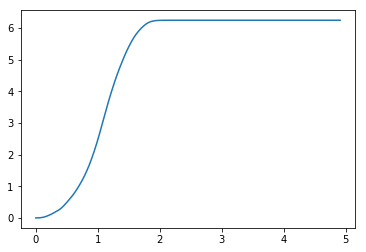

In [138]:
vol_s  = cumu(input_files['netz_67mM']['s'], sigma['netz']['s'])
vol_o  = cumu(input_files['netz_67mM']['o'], sigma['netz']['o'])
vol_os = cumu(input_files['netz_67mM']['os'], sigma['netz']['os'])
vol_ob = cumu(input_files['netz_67mM']['ob'], sigma['netz']['ob'])
vol_c  = cumu(input_files['netz_67mM']['c'], sigma['netz']['c'])
vol_cs = cumu(input_files['netz_67mM']['cs'], sigma['netz']['cs'])
vol_h1 = cumu(input_files['netz_67mM']['h1'], sigma['netz']['h1'])
vol_hc = cumu(input_files['netz_67mM']['hc'], sigma['netz']['hc'])

vol = vol_s + vol_o + vol_os + vol_ob + vol_c + vol_cs + vol_h1 + vol_hc

plt.plot(r[1:], vol)
#for i in range(len(vol)):
    #print(r[i], '\t', vol[i])